# Pass Difficulty with Neural Networks

##### Using convolutional neural networks to create pass difficulty surfaces

This work is highly motivated by the recent [SoccerMap](https://whova.com/embedded/subsession/ecmlp_202009/1194275/1194279/) paper published by [Javier Fernandez](https://twitter.com/JaviOnData) and [Luke Bornn](https://twitter.com/LukeBornn) which provided a deep learning architecture for producing probability surfaces from raw tracking data. It's really brilliant, and you should take a look. This notebook is an exercise in applying some of the major learnings from their paper, in particular the evaluation of a loss function at a single output pixel, to the less-exclusive event-based domain.

Using StatsBomb's Open Data from the 2018 World Cup, we aim to produce continuous pass completion probability surfaces given the originating location of the pass. Naturally, our predictions offer less flexibility and precision as those produced with the richer context found in full tracking data, but I think this offers a possible improvement on many existing pass probability models in the event-based domain. And it produces some really attractive plots along the way.

---

In [1]:
# This builds the soccerutils module in the Analytics Handbook so you can import it
!pip install git+https://github.com/devinpleuler/analytics-handbook.git

  Cloning https://github.com/devinpleuler/analytics-handbook.git to /private/var/folders/v5/66bhl9b133l8pphg81wp7rpm0000gp/T/pip-req-build-_hyou5d6
  Created wheel for AnalyticsHandbook: filename=AnalyticsHandbook-0.2.dev0-py3-none-any.whl size=15461 sha256=192118fe9e86adf2c2fa8ac11253b4aed5a5c681e20744f0a89489370473f456
  Stored in directory: /private/var/folders/v5/66bhl9b133l8pphg81wp7rpm0000gp/T/pip-ephem-wheel-cache-n9s8jmdx/wheels/1e/45/36/ddd80670af7d4a73e4f7a5877b5c47face9ed155b38351e50e
Successfully built AnalyticsHandbook


In [2]:
from soccerutils.statsbomb import get_events
from soccerutils.pitch import Pitch

Like previous examples, we import `get_events` from the `soccerutils.statsbomb` module, which loads all events from a single competition/season into a simple list.

We also import the `Pitch` class from `soccerutils.pitch`, which we can use to plot field lines.


In [3]:
import numpy as np
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [4]:
events = get_events(competition_id=43, season_id=3)

Get all 2018 World Cup events and put them into the events list.

---

In [5]:
def transform(coords, x_bins=52, y_bins=34):
    x, y = coords
    
    x_bin = np.digitize(x, np.linspace(0, 120, x_bins))
    y_bin = np.digitize(y, np.linspace(0, 80, y_bins))
  
    matrix = np.zeros((x_bins, y_bins))
    try:
        matrix[x_bin][y_bin] = 1
    except IndexError:
        pass
    
    return matrix

def build_tensor(point, x_bins=52, y_bins=34):    
    xx = np.linspace(0, 120, x_bins)
    yy = np.linspace(0, 80, y_bins)
    xv, yv = np.meshgrid(xx, yy, sparse=False, indexing='ij')
    coords = np.dstack([xv, yv])
    
    origin = np.array(point)
    goal = np.array([120,40])
    
    pos = transform(point)
    r_origin = np.linalg.norm(origin - coords, axis=2)
    r_goal = np.linalg.norm(goal - coords, axis=2)
    
    tensor = np.dstack([pos, r_origin, r_goal])
            
    return tensor

We use `transform()` and `build_tensor()` to help construct our training data. You can see the outputs of these functions in spatial form a little bit further down in the notebook.

I highly recommend using `numpy` vectoried approaches to the construction of these surfaces, otherwise you're gonna be sitting around for a while waiting for your training data to populate.

Note: we borrow some of the matrix dimensions from `SoccerMap`, working at 1/2, and 1/4 size of their 104 x 68 representation.

---

In [6]:
from tqdm import tqdm

In [7]:
passes= []
for e in tqdm(events):
    if e['type']['id'] == 30: # Events with type ID == 30 are Passes
        passes.append({
            'player': e['player'],
            'origin': build_tensor(e['location']),
            'dest': transform(e['pass']['end_location']),
            'outcome': 0 if 'outcome' in e['pass'].keys() else 1
        })

100%|██████████| 227886/227886 [00:29<00:00, 7622.91it/s]


In [8]:
Xp = np.asarray([p['origin'] for p in passes])
Xd = np.asarray([p['dest'] for p in passes])
Y = np.asarray([p['outcome'] for p in passes], dtype=np.float32)

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
Xp_train, Xp_test, \
Xd_train, Xd_test, \
Y_train, Y_test = train_test_split(Xp, Xd, Y,
                                   test_size=0.1,
                                   random_state = 1,
                                   shuffle=True)

This splits our data 90/10 into seperate training and testing groups.

---

In [33]:
n = 500 # We use this sample index through the entire notebook

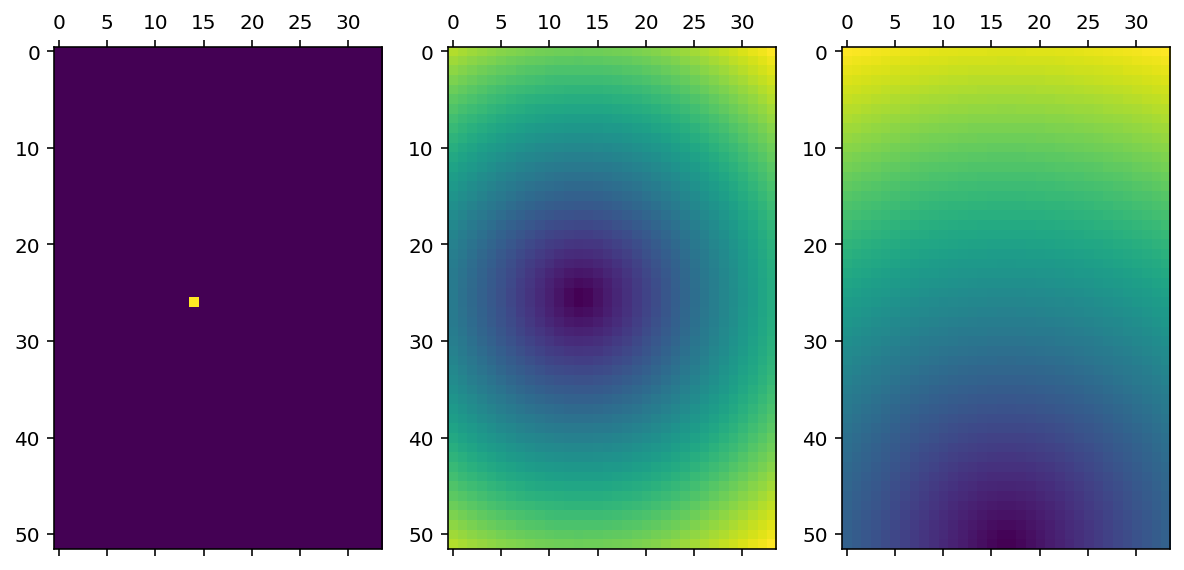

In [34]:
fig, axs = plt.subplots(1,3, figsize=(10,8))
for i, ax in enumerate(axs):
    ax.matshow(Xp_test[n][:,:,i])

Like the approach suggested in `SoccerMap`, we produce an `l x w x c` matrix, where `l` (*length*) and `w` (*width*) represent coarsened locations on a field and `c` represents *channels* of information that are binned into the spatial representation in the first two dimensions.

Unlike `SoccerMap`, we don't have to represent player-by-player locations and velocities, but we do construct various channels that represent spatial relationships between the origin of the pass and the goal. We also include a sparse channel that represents the cell that belongs to the origin of the pass.

---

In [13]:
avg_completion_rate = np.mean(Y_train)
print(avg_completion_rate)

0.7975862


We initialize the final prediction surface with the `avg_completion_rate` to speed up training.

---

In [14]:
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Lambda
from keras.models import Model
from keras.initializers import Constant
import keras.backend as K

In [15]:
from tensorflow import pad, constant
# I couldn't figure out how to do padding with the Keras backend

def symmetric_pad(x):
    paddings = constant([[0, 0], [1, 1], [1, 1], [0, 0]])
    return pad(x, paddings, "SYMMETRIC")

Getting the padding right is critical for reducing artifacting along the edges of our probability surfaes. As convolutions reduce the size of your representations (depending on their kernal size and stride), you need to return your representations to the original size.

`Symmetric Padding` is particularly useful for this situation as it fills the padding cells with values that are similar to those around it, unlike `same` padding which fills those cells with a constant value.

We apply this sort of padding after any convolution layers that have kernel sizes other than `(1,1)`.

---

In [16]:
def pixel_layer(x):
    surface = x[:,:,:,0]
    mask = x[:,:,:,1]
    masked = surface * mask
    value = K.sum(masked, axis=(2,1))    
    return value

This custom single-pixel layer is critical piece to evaluating loss during model training.

As you can see in the model structure below, we pass in two seperate inputs. One is the training data that we construct via `build_tensor()`, but we also pass in the sparse spatial representation of the destination as a seperate input.

We borrow that layer to *mask* (via multiplication) the final prediction surface such that we can grab the prediction at the cell on the surface that matches the actual destination of the pass and compare it to the true value with log loss.

In [17]:
pass_input = Input(shape=(52,34,3), name='pass_input')
dest_input = Input(shape=(52,34,1), name='dest_input')

x = Conv2D(16, (3, 3), activation='relu', padding='valid')(pass_input)
x = Lambda(symmetric_pad)(x)
x = Conv2D(1, (1, 1), activation='linear')(x)

x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='valid')(x)
x = Lambda(symmetric_pad)(x)
x = Conv2D(1, (1, 1), activation='linear')(x)

x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu', padding='valid')(x)
x = Lambda(symmetric_pad)(x)
out = Conv2D(1, (1,1), activation='sigmoid',
             kernel_initializer=Constant(avg_completion_rate))(x)

combined = Concatenate()([out, dest_input])
pixel = Lambda(pixel_layer)(combined)

model = Model([pass_input, dest_input], combined)
full = Model([pass_input, dest_input], pixel)

Notice that we define two seperate models, `model` and `full`. One the subset of the other.

We will use `model` to produce surfaces, while we use `full` to produce predictions at just the destination coordinates of the pass

---

In [18]:
# full.summary()
# If you're interested in seeing the layer-by-layer dimensions, run this cell.

In [19]:
full.compile(loss="binary_crossentropy", optimizer="adam")

In [20]:
fit = full.fit(
    [Xp_train, Xd_train], Y_train,
    epochs=30,
    validation_data=([Xp_test, Xd_test], Y_test))

Epoch 1/30
1769/1769 [==============================] - 63s 36ms/step - loss: 0.4357 - val_loss: 0.4267
Epoch 2/30
1769/1769 [==============================] - 59s 33ms/step - loss: 0.4073 - val_loss: 0.4053
Epoch 3/30
1769/1769 [==============================] - 55s 31ms/step - loss: 0.3970 - val_loss: 0.4029
Epoch 4/30
1769/1769 [==============================] - 56s 32ms/step - loss: 0.3895 - val_loss: 0.3971
Epoch 5/30
1769/1769 [==============================] - 59s 33ms/step - loss: 0.3868 - val_loss: 0.3904
Epoch 6/30
1769/1769 [==============================] - 60s 34ms/step - loss: 0.3841 - val_loss: 0.3934
Epoch 7/30
1769/1769 [==============================] - 59s 33ms/step - loss: 0.3825 - val_loss: 0.3884
Epoch 8/30
1769/1769 [==============================] - 59s 33ms/step - loss: 0.3803 - val_loss: 0.3892
Epoch 9/30
1769/1769 [==============================] - 61s 34ms/step - loss: 0.3805 - val_loss: 0.3856
Epoch 10/30
1769/1769 [==============================] - 66s 37m

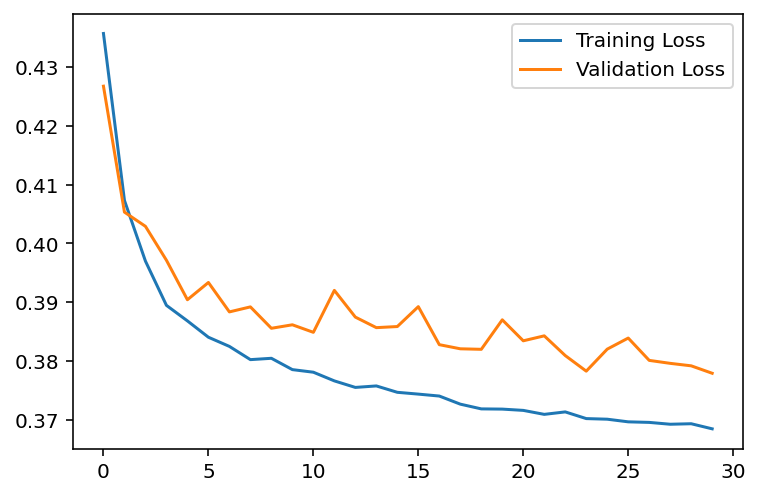

In [21]:
train_loss = fit.history['loss']
test_loss = fit.history['val_loss']
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label="Validation Loss")
plt.legend(loc='best')
plt.show()

Plotting the model loss during training for the training and validation data sets.

---

In [22]:
surfaces = model.predict([Xp_test, Xd_test])

Construct surfaces from the test data

---

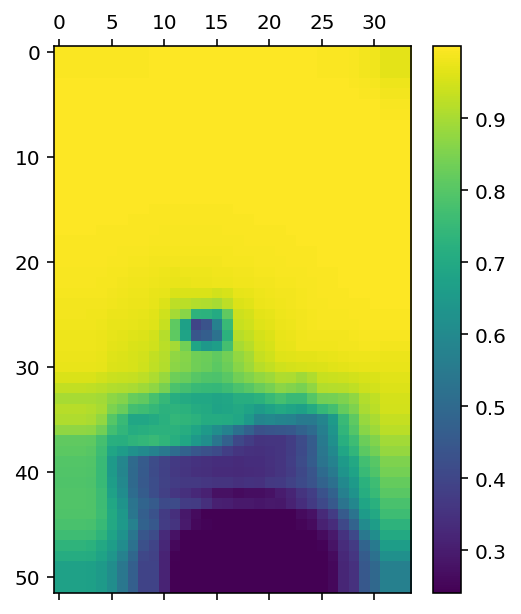

In [35]:
s = plt.matshow(surfaces[n][:,:,0])
plt.colorbar(s, shrink=0.8)

Notice the dimples in pass difficult around the origin of the pass. This is due to survivorship bias cased by incomplete passes being cut out before they reach their intended destination. In particular, this happens frequently with blocked passes near the origin, causing this interesting artifact. In an ideal world, we would be using the intended destinatino of the pass as opposed to the actuaion destination, but that's impossible in the event-based domain.

In [24]:
from scipy.ndimage import gaussian_filter

In [47]:
def draw_map(img, pass_, title=None, dims=(52,34)):
    image = gaussian_filter((img).reshape(dims), sigma=1.8)
    fig, ax = plt.subplots(figsize=(8,6))

    pitch = Pitch(title=title)
    pitch.create_pitch(ax)

    z = np.rot90(image, 1)

    xx = np.linspace(0, 120, 52)
    yy = np.linspace(0, 80, 34)

    c = ax.contourf(
        xx, yy, z,
        zorder=2,
        levels=np.linspace(0.2, 1.0, 17),
        alpha=0.8,
        antialiased=True,
        cmap='RdBu')

    x,y = np.unravel_index(pass_.argmax(), pass_.shape)
    y = dims[1] - y
    origin = np.asarray([x,y])*[120/dims[0],80/dims[1]]

    cosmetics = {
        'linewidth': 1,
        'facecolor': "yellow",
        'edgecolor': "black",
        'radius': 1.5,
        'zorder': 5
    }

    pitch.draw_points(ax, [origin], cosmetics=cosmetics)

    ax.set_aspect(1)
    ax.axis('off')

    plt.tight_layout()
    plt.colorbar(c, ax=ax, shrink=0.6)
    plt.show()

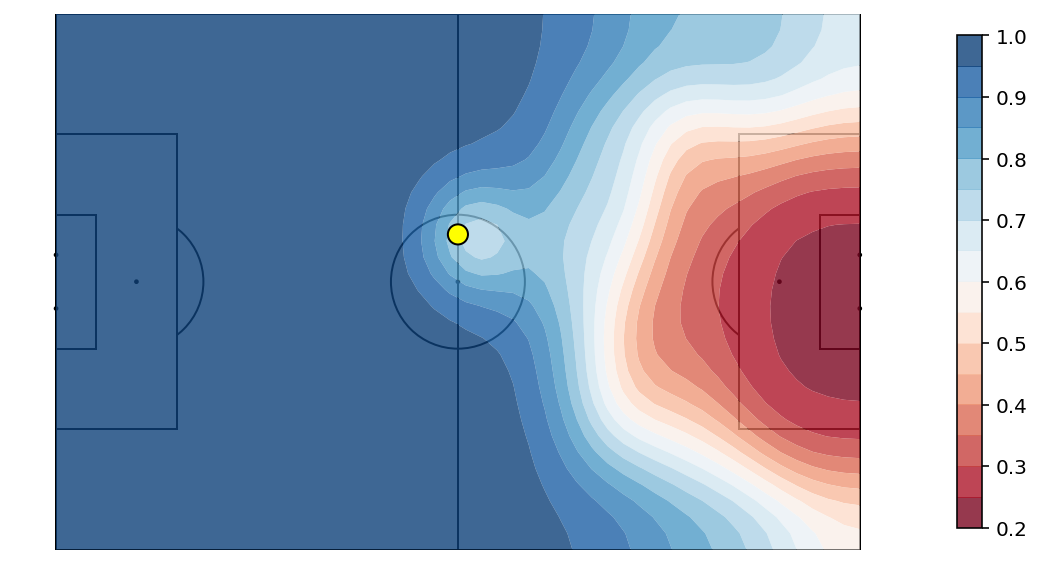

In [48]:
surface = surfaces[n][:,:,0]
draw_map(surface, Xp_test[n][:,:,0])

In [27]:
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.calibration import calibration_curve

In [28]:
predictions = full.predict([Xp_test, Xd_test])

Notice, we pull predictions from the `full` model since we're only interested in the predictions at the destination coordinates, not the full surface.

---

In [29]:
fraction_of_positives, mean_predicted_value = calibration_curve(Y_test, predictions, n_bins=10)

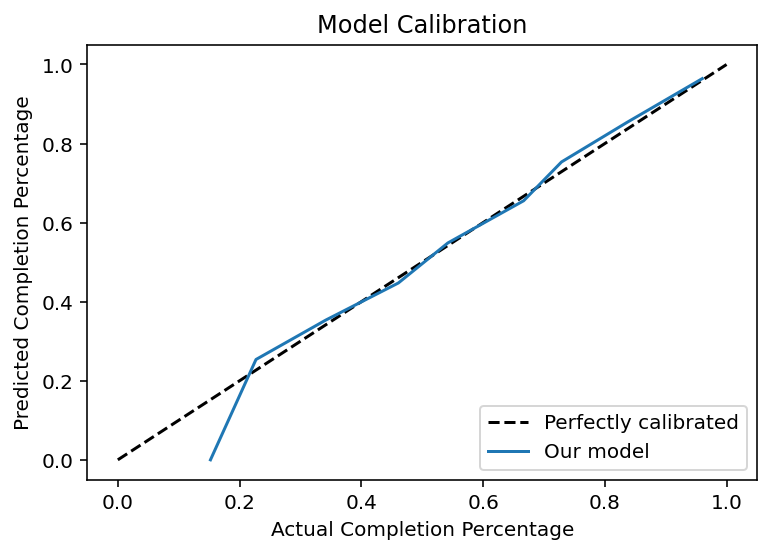

In [30]:
plt.plot([0, 1], [0, 1], "k--", label="Perfectly calibrated")
plt.plot(fraction_of_positives, mean_predicted_value, label="Our model")
plt.xlabel('Actual Completion Percentage')
plt.ylabel('Predicted Completion Percentage')
plt.title('Model Calibration')
plt.legend(loc="lower right")

plt.show()

Model struggles a bit at the bottom end, which isn't entirely surprising. Not a huge sample size down there.

---

In [31]:
fpr, tpr, _ = roc_curve(Y_test, predictions)
auc = roc_auc_score(Y_test, predictions)

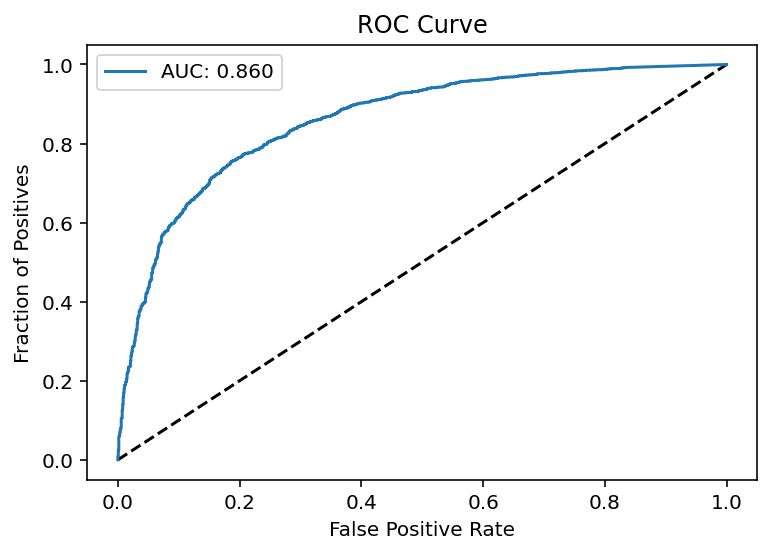

In [32]:
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label="AUC: {:.3f}".format(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('Fraction of Positives')
plt.title('ROC Curve')
plt.legend(loc='best')
plt.show()

This is actually pretty competitive performance, especially before really tuning hyper parameters and the limited sample size provided by just 64 games of World Cup play.

We're also leaving various other bits of qualitative information that are tagged on a per-pass basis (e.g. `goal-kick` or `is-cross` that can be leveraged to improved predictions further.

---

Devin Pleuler 2020